# Supplementary Material plots for data representativeness

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [45]:
import os
from sklearn import linear_model
from adjustText import adjust_text
from scipy.stats import pearsonr
import random as rnd
import math

In [46]:
data = pd.read_csv("../../preprocessed/reviews_master_no_text.csv", low_memory=False)

In [47]:
data.head(2)

,company_id,date,employee_status,employee_title,location,post_index,rating_overall,stress_post,company_name,post_id,state,Region,Division,GICSSector,GICSSubIndustry,Headquarters Location,quarter,year,half-year
0,1_comerica,Wed May 06 2020 07:27:34 GMT+0100 (British Sum...,Current Employee,Analyst,"Dallas, TX",1.0,5.0,0.0,comerica,1_comerica,TX,South,West South Central,Financials,Diversified Banks,"Dallas, Texas",2020 Q2,2020,2020 1st-half
1,4_comerica,Tue Mar 10 2020 09:03:58 GMT+0000 (Greenwich M...,Former Employee,Customer Service Representative,"Dallas, TX",4.0,4.0,0.0,comerica,4_comerica,TX,South,West South Central,Financials,Diversified Banks,"Dallas, Texas",2020 Q1,2020,2020 1st-half


## Temporal plots: total and reviews with stress through time

In [48]:
yearly_data = data.groupby(by=['year'])['company_id'].nunique().\
                reset_index().rename(columns={'company_id':'# posts'})

In [49]:
yearly_data['log(# posts)'] = yearly_data['# posts'].apply(np.log10)

In [50]:
yearly_stress_data = data[data['stress_post']==1].groupby(by=['year'])['company_id'].nunique().\
                reset_index().rename(columns={'company_id':'# stress posts'})

In [51]:
yearly_stress_data['log(# stress posts)'] = yearly_stress_data['# stress posts'].apply(np.log10)

In [52]:
yearly = yearly_data.merge(yearly_stress_data, on=['year'])

In [53]:
yearly.corr()

,year,# posts,log(# posts),# stress posts,log(# stress posts)
year,1.000000,0.656468,0.726535,0.633194,0.686325
# posts,0.656468,1.000000,0.968723,0.995425,0.964203
log(# posts),0.726535,0.968723,1.000000,0.970804,0.996541
# stress posts,0.633194,0.995425,0.970804,1.000000,0.973165
log(# stress posts),0.686325,0.964203,0.996541,0.973165,1.000000


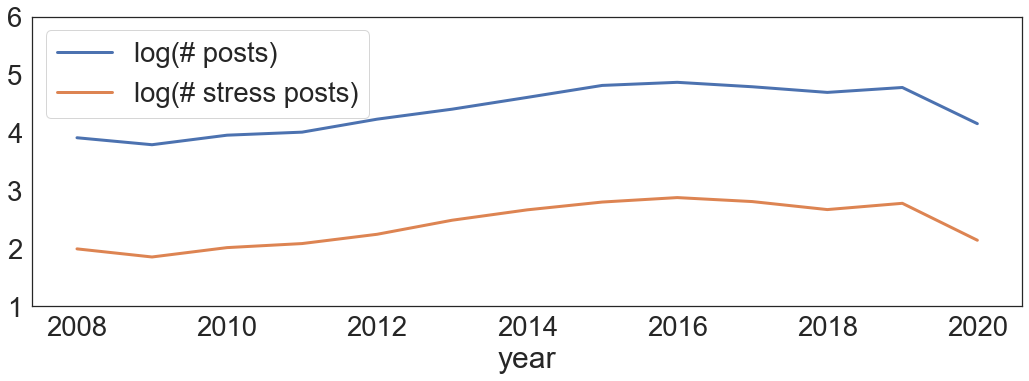

In [54]:
sns.set(style='white', font_scale=2.5)
fig, ax = plt.subplots(figsize=(15,6))
yearly.plot(x='year', y=['log(# posts)', 'log(# stress posts)'],ax=ax, linewidth=3)
plt.ylim([1,6])
plt.tight_layout()
plt.savefig('../../results/representativeness_temporal_num_posts.png', dpi=100)

# Spatial plots: number of reviews against state population

In [55]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
def LR_res_outliers(df, col_y, col_x, names,\
                    col_y_name, col_x_name,\
                    title='',\
                    log=True, to_mark=[], PCT_TO_PLOT=.3,\
                    top_N=0):
    """
        given df with columns we want to plot:
        'col_x' and 'col_y', and the markers column 'names';
        scatter plots the values (you can make them logged with log=True);
        finds 'topN' outliers and
        on the rest of the points fits a linear regression line;
        it randomly marks 'PCT_TO_PLOT' regular points and
        also highlights all the outliers;
        'to_mark' holds labels that we neccessarily want to mark, e.g., important states.
    """
    
    # if labels for axes were not specified
    if col_y_name == None:
        col_y_name=col_y
    if col_x_name == None:
        col_x_name=col_x
    
    
    """
        scatter plot
    """
    s = df.copy()
    fig, ax = plt.subplots(figsize=(13,13))
    sns.scatterplot(ax=ax, x=s[col_x], y=s[col_y], s=220)
    if log:
        ax.set(xscale="log", yscale="log")
        col_x_name = "log(" + col_x_name + ")"
        col_y_name = "log(" + col_y_name + ")"
    ax.set_xlabel(col_x_name)
    ax.set_ylabel(col_y_name)
        
    """
        prepare texts for labelling regular markers
    """
    X = np.array(s[col_x].astype(int)).flatten()
    y = np.array(s[col_y].astype(int)).flatten()
    X_LR = X.reshape(-1, 1)
    y_LR = y
    labels = s[names]
    texts = []
    for xi, yi, text in zip(X, y, labels):
        random_num = rnd.random()
        if text in to_mark:
            texts.append(ax.text(xi, yi, text))
            continue
        if random_num < PCT_TO_PLOT:
            texts.append(ax.text(xi, yi, text))
    
    """
        first linear model to determine outliers
    """
    if log:
        X_LR = np.log(X_LR)
        y_LR = np.log(y_LR)  
    lm = linear_model.LinearRegression()
    model = lm.fit(X_LR,y_LR)
    res = np.linalg.norm(y_LR - lm.predict(X_LR)) ** 2
    residuals = y_LR - lm.predict(X_LR)    
    s["residuals"] = np.abs(residuals)
    tmps = s.sort_values(by=["residuals"], ascending=False)
    
    """
        prepare texts for labelling outliers
    """   
    outlier_texts = []   
    X_outliers = np.array(tmps.head(top_N)[col_x].astype(int)).flatten()
    y_outliers = np.array(tmps.head(top_N)[col_y].astype(int)).flatten()
    outliers_labels = list(tmps.head(top_N)[names])
    for xi, yi, text in zip(X_outliers, y_outliers, outliers_labels):
        outlier_texts.append(ax.text(xi, yi, s=text, color='red'))
   
    """
        remove from the original texts the found outliers
    """   
    texts = [lab for lab in texts if (lab not in outlier_texts) ]
    # mark both regular texts and outlier texts
    adjust_text(texts, force_text=0.7, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    adjust_text(outlier_texts, force_text=0.7, arrowprops=dict(arrowstyle='-', color='red', lw=0.5))

    """
        second linear model to report (after removal of outliers)
    """   
    X_no_outliers = np.array([el for el in X if (el not in X_outliers) ])
    y_no_outliers = np.array([el for el in y if (el not in y_outliers) ])
    X_no_outliers_LR = X_no_outliers.reshape(-1, 1)
    y_no_outliers_LR = y_no_outliers
    if log:
        X_no_outliers_LR = np.log(X_no_outliers_LR)
        y_no_outliers_LR = np.log(y_no_outliers_LR)  
    lm2 = linear_model.LinearRegression()
    model = lm2.fit(X_no_outliers_LR,y_no_outliers_LR)
    y_pred_no_outliers_LR = lm2.predict(X_no_outliers_LR)  # make predictions
    if log:
        plt.plot(np.exp(X_no_outliers_LR), np.exp(y_pred_no_outliers_LR), color='gray')
    else:
        plt.plot(X_no_outliers_LR, y_pred_no_outliers_LR, color='gray')

    pearson_coef = pearsonr(np.array(X_no_outliers_LR).flatten(),np.array(y_no_outliers_LR).flatten())

    plt.title(title + r" $\beta$=" + str("{0:.2f}").format(lm2.coef_[0]) + \
              "; r=" + str("{0:.2f}").format(pearson_coef[0]) + \
             "; p=" + str("{0:.2f}").format(pearson_coef[1]))
    
    ax.get_figure().savefig('../../results/'+title+'_LR_res_plot.png', dpi=100)

In [56]:
# US_states_geo

In [57]:
US_states_geo = pd.read_csv('../../data/us_states_geo.csv')
US_states_geo.rename(columns={'state':'state full', 'state_code':'state'}, inplace=True)
US_states_geo = US_states_geo.set_index('state')

In [58]:
reviews = data.groupby(by=['state'])['company_id'].nunique().reset_index().\
            rename(columns={'company_id':'# posts'}).set_index('state')

In [59]:
reviews = reviews.join(US_states_geo)
reviews = reviews.reset_index()

In [60]:
reviews = reviews[['state', '# posts', 'population_2019']]

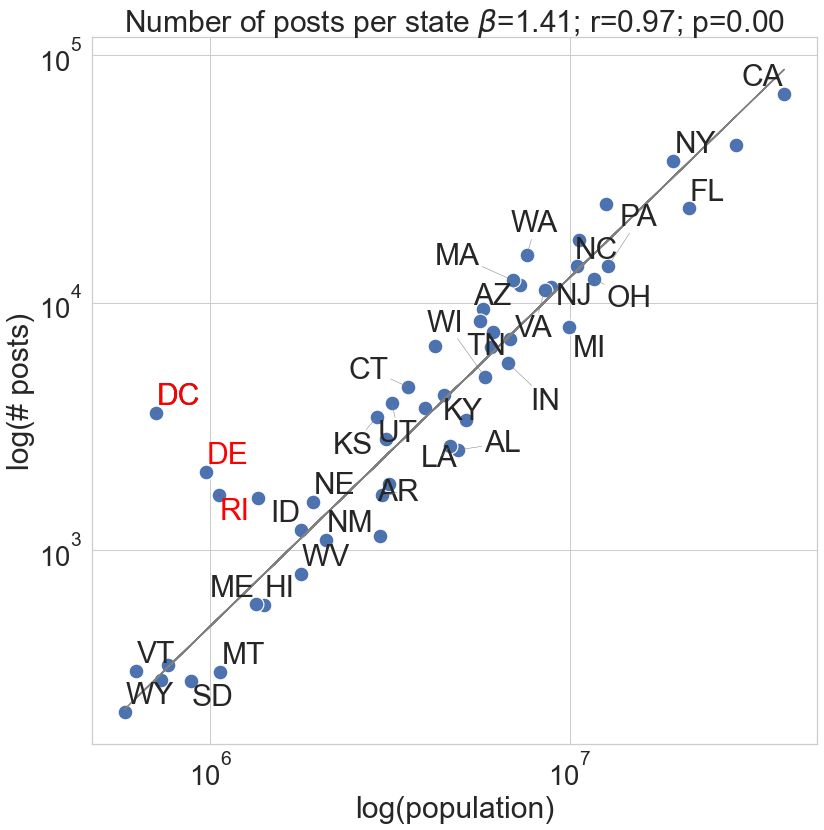

In [61]:
LR_res_outliers(df=reviews, col_y='# posts', col_x='population_2019', names='state',\
                col_y_name='# posts', col_x_name='population',\
                title='Number of posts per state',\
                log=True, to_mark=['CA', 'FL', 'DC'], PCT_TO_PLOT=.6, top_N=3)

# Industry Types plots: number of companies per industry sector for the four stress types

In [62]:
quadrants = pd.read_csv("../../preprocessed/company_master.csv")
quadrants.rename(columns={'company':'company_name'}, inplace=True)

# sectors = data[['company_name', 'GICSSector']].drop_duplicates()
sectors = quadrants.copy()

In [63]:
sectors

,Unnamed: 0,company_name,total_posts,sym_posts,pct_stress,rating_balance,rating_career,rating_comp,rating_culture,rating_mgmt,...,log_stock_growth_2014,stock_growth_2012,log_stock_growth_2012,stock_growth_2009,log_stock_growth_2009,log_stock_2009,log_stock_2012,log_stock_2014,log_stock_2019,GICSSector
0,0,homedepot,21695,146,0.993270,3.071237,3.236157,3.166929,3.532724,2.963304,...,0.996437,4.503229,1.504795,10.548870,2.356019,2.946619,3.797843,4.306201,5.302638,Consumer Discretionary
1,1,jpmorgan,18455,125,0.993227,3.277048,3.518595,3.567632,3.469825,3.131611,...,0.807549,3.516224,1.257388,4.069287,1.403468,3.284491,3.430571,3.880410,4.687959,Financials
2,2,apple,15345,209,0.986380,3.374468,3.473904,4.035394,4.022310,3.442257,...,0.901050,2.884171,1.059238,11.343985,2.428688,1.501064,2.870514,3.028701,3.929751,Information Technology
3,3,bankofamerica,15280,185,0.987893,3.352568,3.321248,3.619090,3.326979,2.903200,...,0.669508,3.808417,1.337214,2.634336,0.968631,2.385372,2.016790,2.684496,3.354004,Financials
4,4,amazon,12660,138,0.989100,3.309610,3.755939,3.805228,3.707052,3.330055,...,1.682725,8.121469,2.094511,20.498989,3.020376,4.469142,5.395007,5.806793,7.489518,Consumer Discretionary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,376,cmsenergy,10,0,1.000000,3.187500,3.428571,3.142857,3.000000,3.000000,...,0.813335,3.170358,1.153845,6.547452,1.879076,2.136869,2.862101,3.202610,4.015945,Utilities
376,377,hosthotelsandresorts,10,0,1.000000,3.222222,2.333333,4.000000,2.833333,2.500000,...,0.042796,1.513325,0.414309,2.929668,1.074889,1.762271,2.422850,2.794363,2.837160,Real Estate
377,378,foxcorp,10,0,1.000000,4.222222,3.333333,3.333333,3.666667,3.222222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.381074,Communication Services
378,379,howmetaerospace,4,0,1.000000,3.500000,4.000000,4.000000,3.750000,3.250000,...,-0.262639,1.247286,0.220970,1.085344,0.081897,3.091882,2.952809,3.436418,3.173780,Industrials


In [64]:
NOMAP_Q_dict = {
    'Q1': "seagreen",
    'Q2': "black",
    'Q3': "firebrick",
    'Q4': "gold"
}

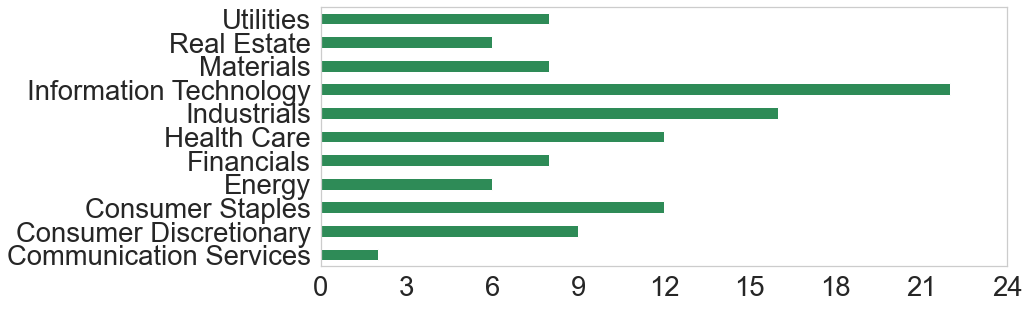

In [65]:
fig, ax = plt.subplots(figsize=(15,5))
Q ='Q1'
df_Q = sectors[sectors['Q']==Q]
df_Q = df_Q.groupby('GICSSector')['company_name'].count()
df_Q.plot.barh('GICSSector', color=NOMAP_Q_dict[Q], ax=ax)
ax.grid(False)
plt.ylabel('')
plt.xlim(0, 24)
# plt.xticks(range(0,23))
plt.xticks(np.arange(0, 25, 3))
plt.tight_layout()
plt.savefig('../../results/sectors_'+Q+'.png', dpi=150)

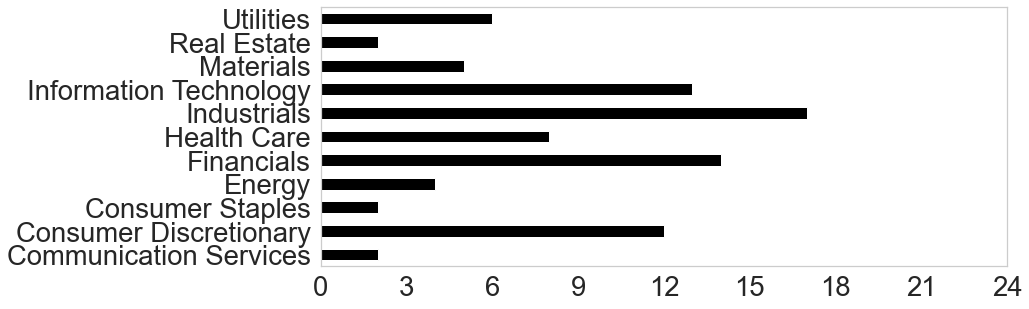

In [66]:
fig, ax = plt.subplots(figsize=(15,5))
Q ='Q2'
df_Q = sectors[sectors['Q']==Q]
df_Q = df_Q.groupby('GICSSector')['company_name'].count()
df_Q.plot.barh('GICSSector', color=NOMAP_Q_dict[Q], ax=ax)
ax.grid(False)
plt.ylabel('')
plt.xticks(np.arange(0, 25, 3))
plt.tight_layout()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../results/sectors_'+Q+'.png', dpi=150)

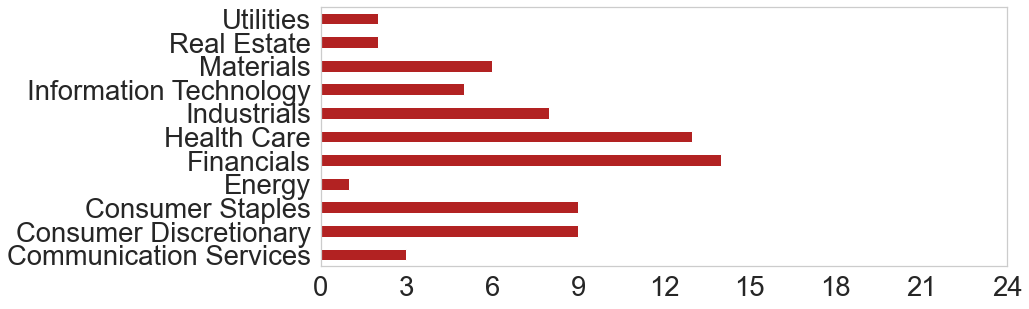

In [67]:
fig, ax = plt.subplots(figsize=(15,5))
Q ='Q3'
df_Q = sectors[sectors['Q']==Q]
df_Q = df_Q.groupby('GICSSector')['company_name'].count()
df_Q.plot.barh('GICSSector', color=NOMAP_Q_dict[Q], ax=ax)
ax.grid(False)
plt.ylabel('')
# plt.xlim(0, 20)
plt.xticks(np.arange(0, 25, 3))
# plt.xlim(range(math.floor(min(0)), math.ceil(max(20))+1))
plt.tight_layout()
plt.savefig('../../results/sectors_'+Q+'.png', dpi=150)

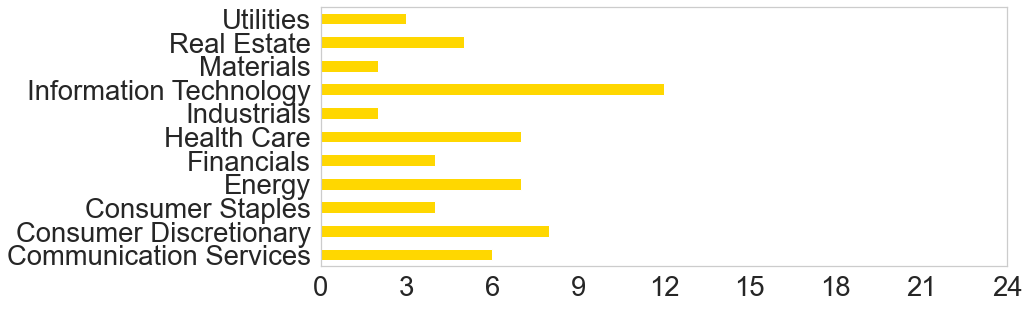

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
Q ='Q4'
df_Q = sectors[sectors['Q']==Q]
df_Q = df_Q.groupby('GICSSector')['company_name'].count()
df_Q.plot.barh('GICSSector', color=NOMAP_Q_dict[Q], ax=ax)
ax.grid(False)
plt.ylabel('')
plt.xticks(np.arange(0, 25, 3))
plt.tight_layout()
plt.savefig('../../results/sectors_'+Q+'.png', dpi=150)